# Assignment \#4: Data Integration, Bias and Fairness

**Overview**

The Notebook consists out of three chapters:
1. **Bias Identification** 
2. **Bias Mitigation**
3. **ML model creation and Fairness Evaluation**

**References**
- The code is available under: [git@github.com:dasiemens-coder/IR_Assignment-4.git](git@github.com:dasiemens-coder/IR_Assignment-4.git)
- The Datasets used are available under 
    - [Dataset 1: Mental Health Dataset.csv](https://www.kaggle.com/datasets/junnn0126/university-students-mental-health)
    - [Dataset 2: Depression Student Dataset.csv](https://www.kaggle.com/datasets/ikynahidwin/depression-student-dataset)

In [ ]:
import aif360
print("AIF360 version:", aif360.__version__)
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.algorithms.inprocessing import AdversarialDebiasing
from aif360.algorithms.preprocessing import Reweighing
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import LabelEncoder
import fairlearn
from fairlearn.metrics import MetricFrame, selection_rate, true_positive_rate, false_positive_rate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt




# Construct the full path to the CSV files
csv_path_student_depression = os.path.join('datasets', 'Depression Student Dataset.csv')
csv_path_mental_health = os.path.join('datasets', 'Mental Health Dataset.csv')

AIF360 version: 0.6.1


## Part 1: Bias Identification

In the first part of this notebook, we load two datasets and evaluate each for biases independently.

### **Process**

1. **Load Datasets:**  Load Dataset 1 and Dataset 2.

2. **Label Encoding:**  Convert all features to numerical values using label encoding.

3. **Age Categorization:**  Categorize participants by age into two groups. For example, in Dataset 1, participants under 25 years are labeled as **0** (younger), and those aged 26 or above are labeled as **1** (older).

4. **Feature Selection:**  Drop any features that are not relevant for the current analysis.

5. **Target Variable:**  Use the binary variable **Depression** as the target variable.

6. **Protected Groups:**  Define the protected attributes as:
   - **Gender** (primary)
   - **Age** (secondary)

7. **Tools Used:**  For the Bias identification & mitigation we use IBM AI 360. 

### **Analysis**

In these datasets, **1** represents the label **Depression**, while **0** indicates **Not Depression**. Although **1** is “positive” in a classification sense, it is an unfavorable health outcome. Below, we summarize fairness metrics—**Statistical Parity Difference (SPD)**, **Disparate Impact (DI)**, and group ratios—for both **Gender** and **Age** in each dataset, clarifying how each label is distributed.


#### **Dataset 1**

- **Statistical Parity Difference (Gender):** -0.03174754960554632  
- **Disparate Impact (Gender):** 0.9385753931544865  
- **Male to Female Ratio:** 1.1361702127659574  

  A **negative SPD** indicates **females** have a slightly lower proportion of “Depression” (1) compared to **males**. While the **DI** (~0.94) is close to 1, the **Male to Female Ratio** (~1.136) tells us there are about 13.6% more **males** than **females** in this dataset overall (this ratio reflects total counts, not the proportion of “Depression” label across genders).

- **Statistical Parity Difference (Age):** -0.18326693227091634  
- **Disparate Impact (Age):** 0.6912751677852349  
- **Over 26 to Under 26 Ratio:** 1.0  

  The **SPD** for age (-0.1833) shows younger participants (under 26) are significantly less likely to be labeled with “Depression.” The **DI** (~0.69) reinforces the disparity, suggesting that younger participants receive the label 31% less often compared to older participants. The age ratio of **1.0** indicates there are equal counts of under-26 and over-26 individuals in the dataset, even though the distribution of the label differs markedly.


#### **Dataset 2**

- **ce (Gender):** 0.04890350877192978  
- **Disparate Impact (Gender):** 1.1096901131333003  
- **Male to Female Ratio:** 0.3157894736842105  

  A **positive SPD** (~0.049) indicates **females** have a slightly higher prevalence of the “Depression” label than **males**. The **DI** (>1) also suggests females receive label 1 more often. The **Male to Female Ratio** (~0.316) reveals that there are considerably fewer **males** than **females** in this dataset (again, overall count rather than label distribution).

- **Statistical Parity Difference (Age):** -0.041598121836594726  
- **Disparate Impact (Age):** 0.9166673690421004  
- **Over 22 to Under 22 Ratio:** 1.570694087403599  

  A slightly negative SPD (-0.042) indicates participants **under 22** are less likely to be labeled with “Depression.” The **DI** (~0.92) is not drastically different from 1, indicating a moderate disparity. However, the **Over 22 to Under 22** ratio (~1.57) implies a larger proportion of older participants in the dataset, which can influence how often the label appears.


### **Interpretation**

- **Gender Differences:**  
  - **Dataset 1**: Males have a mild increase in the proportion of label 1 (Depression).  
  - **Dataset 2**: Females show a slightly higher rate of label 1.  
  In both datasets, the male-to-female ratios reflect overall population counts, not the distribution of the Depression label itself. However in both datasets the Statistical Parity Difference is under 5%. 

- **Age Differences:**  
  In both datasets, younger participants tend to have a lower prevalence of label 1 (Depression), suggesting that older participants are more likely to receive the label (or are more represented in the data).

  

In [121]:
# Read the CSV file into a pandas DataFrame
#df_mental_health = pd.read_csv(csv_path_mental_health)
# List the columns you want to encode
df_student_depression = pd.read_csv(csv_path_student_depression)
categorical_cols_student_depression = ['Gender', 'Depression', 'Financial Stress', 'Family History of Mental Illness', 'Have you ever had suicidal thoughts ?']
#Drop some values for the moment to make the dataset numerical
df_student_depression = df_student_depression.drop(['Sleep Duration', 'Dietary Habits'], axis=1)
# Encode each column in a loop
for col in categorical_cols_student_depression:
    le = LabelEncoder()
    df_student_depression[col] = le.fit_transform(df_student_depression[col])
    # Display the mapping
    print(f"Mapping of {col} to integers:")
    for index, class_ in enumerate(le.classes_):
        print(f"{class_} -> {index}")
        
# Categorize the "Age" feature
df_student_depression['Age_Category'] = df_student_depression['Age'].apply(lambda x: 1 if x > 26 else 0)
#Drop some values for the moment to make the dataset numerical
df_student_depression = df_student_depression.drop(['Age'], axis=1)
# List the value types of the dataset
print("Value types of the dataset:")
print(df_student_depression.dtypes)

# Display the first few rows of the DataFrame
print("Student Depression Dataset:")
print(df_student_depression.head())
#print("\nMental Health Dataset:")
#print(df_mental_health.head())



Mapping of Gender to integers:
Female -> 0
Male -> 1
Mapping of Depression to integers:
No -> 0
Yes -> 1
Mapping of Financial Stress to integers:
1 -> 0
2 -> 1
3 -> 2
4 -> 3
5 -> 4
Mapping of Family History of Mental Illness to integers:
No -> 0
Yes -> 1
Mapping of Have you ever had suicidal thoughts ? to integers:
No -> 0
Yes -> 1
Value types of the dataset:
Gender                                     int64
Academic Pressure                        float64
Study Satisfaction                       float64
Have you ever had suicidal thoughts ?      int64
Study Hours                                int64
Financial Stress                           int64
Family History of Mental Illness           int64
Depression                                 int64
Age_Category                               int64
dtype: object
Student Depression Dataset:
   Gender  Academic Pressure  Study Satisfaction  \
0       1                2.0                 4.0   
1       1                4.0                 5.0   

In [122]:
# Read the CSV file into a pandas DataFrame
#df_mental_health = pd.read_csv(csv_path_mental_health)
# List the columns you want to encode
df_meantal_health = pd.read_csv(csv_path_mental_health)
df_meantal_health['YearOfStudy'] = df_meantal_health['YearOfStudy'].astype(str).str.lower()
df_meantal_health['Course'] = df_meantal_health['Course'].astype(str).str.lower()
# Convert study hours per week to study hours per day
df_meantal_health['Study Hours'] = df_meantal_health['StudyHoursPerWeek'] / 7
df_meantal_health = df_meantal_health.drop(['StudyHoursPerWeek'], axis=1)
categorical_cols_mental_health = ['Gender', 'Course', 'YearOfStudy']
#Drop some values for the moment to make the dataset numerical
df_meantal_health = df_meantal_health.drop(['Timestamp'], axis=1)
# Encode each column in a loop
for col in categorical_cols_mental_health:
    le = LabelEncoder()
    df_meantal_health[col] = le.fit_transform(df_meantal_health[col])
    # Display the mapping
    print(f"Mapping of {col} to integers:")
    for index, class_ in enumerate(le.classes_):
        print(f"{class_} -> {index}")
        
# Categorize the "Age" feature
df_meantal_health['Age_Category'] = df_meantal_health['Age'].apply(lambda x: 1 if x > 22 else 0)
#Drop some values for the moment to make the dataset numerical
#df_meantal_health = df_meantal_health.drop(['Age'], axis=1)
print(df_meantal_health['Age'].unique())

# List the value types of the dataset
print("Value types of the dataset:")
print(df_meantal_health.dtypes)

# Display the first few rows of the DataFrame
print("Student Depression Dataset:")
print(df_meantal_health.head())
#print("\nMental Health Dataset:")
#print(df_mental_health.head())

Mapping of Gender to integers:
Female -> 0
Male -> 1
Mapping of Course to integers:
accounting  -> 0
ala -> 1
banking studies -> 2
bcs -> 3
benl -> 4
biomedical science -> 5
biotechnology -> 6
bit -> 7
business administration -> 8
communication  -> 9
cts -> 10
diploma nursing -> 11
diploma tesl -> 12
econs -> 13
engin -> 14
engine -> 15
engineering -> 16
enm -> 17
fiqh -> 18
fiqh fatwa  -> 19
human resources -> 20
human sciences  -> 21
irkhs -> 22
islamic education -> 23
it -> 24
kenms -> 25
kirkhs -> 26
koe -> 27
kop -> 28
law -> 29
laws -> 30
malcom -> 31
marine science -> 32
mathemathics -> 33
mhsc -> 34
nursing  -> 35
pendidikan islam -> 36
pendidikan islam  -> 37
psychology -> 38
radiography -> 39
taasl -> 40
usuluddin  -> 41
Mapping of YearOfStudy to integers:
year 1 -> 0
year 2 -> 1
year 3 -> 2
year 4 -> 3
[24 18 25 20 19 21 23 22]
Value types of the dataset:
Gender                          int64
Age                             int64
Course                          int64
YearOfS

In [123]:

dataset_student_depression_gender = BinaryLabelDataset(
    df=df_student_depression,
    label_names=['Depression'],
    protected_attribute_names=['Gender']
)
privileged_groups_gender = [{'Gender': 1}]
unprivileged_groups_gender = [{'Gender': 0}]

dataset_student_depression_age = BinaryLabelDataset(
    df=df_student_depression,
    label_names=['Depression'],
    protected_attribute_names=['Age_Category']
)
privileged_groups_age = [{'Age_Category': 0}]
unprivileged_groups_age = [{'Age_Category': 1}]

# Create a metric object using your dataset and group definitions
metric_depression_gender = BinaryLabelDatasetMetric(
    dataset_student_depression_gender,
    privileged_groups=privileged_groups_gender,
    unprivileged_groups=unprivileged_groups_gender
)

# Compute bias metrics
stat_parity_diff_gender = metric_depression_gender.mean_difference()   # Statistical Parity Difference
disparate_impact_gender = metric_depression_gender.disparate_impact()    # Disparate Impact

print("Statistical Parity Difference (gender):", stat_parity_diff_gender)
print("Disparate Impact (gender):", disparate_impact_gender)
# Calculate the ratio of males to females
male_count = (df_student_depression['Gender'] == 1).sum()
female_count = (df_student_depression['Gender'] == 0).sum()
male_to_female_ratio = male_count / female_count if female_count != 0 else None

print("Male to Female Ratio:", male_to_female_ratio)

# Create a metric object using your dataset and group definitions
metric_depression_age = BinaryLabelDatasetMetric(
    dataset_student_depression_age,
    privileged_groups=privileged_groups_age,
    unprivileged_groups=unprivileged_groups_age
)

# Compute bias metrics
stat_parity_diff_age = metric_depression_age.mean_difference()   # Statistical Parity Difference
disparate_impact_age = metric_depression_age.disparate_impact()    # Disparate Impact

print("Statistical Parity Difference (age):", stat_parity_diff_age)
print("Disparate Impact (age):", disparate_impact_age)
over_26_count = (df_student_depression['Age_Category'] == 0).sum()
under_26_count = (df_student_depression['Age_Category'] == 1).sum()
over_to_under_26_ratio = over_26_count / under_26_count
#Age in Dataset Varies from 18 to 30 years
print("Over 26 to Under 26 Ratio:", over_to_under_26_ratio)

Statistical Parity Difference (gender): -0.03174754960554632
Disparate Impact (gender): 0.9385753931544865
Male to Female Ratio: 1.1361702127659574
Statistical Parity Difference (age): -0.18326693227091634
Disparate Impact (age): 0.6912751677852349
Over 26 to Under 26 Ratio: 1.0


In [124]:

#print(df_meantal_health['Gender'].unique()) 
dataset_mental_health_gender = BinaryLabelDataset(
    df=df_meantal_health,
    label_names=['Depression'],
    protected_attribute_names=['Gender'], 
)
privileged_groups = [{'Gender': 1}] #Men
unprivileged_groups = [{'Gender': 0}] #Woman

dataset_mental_health_age = BinaryLabelDataset(
    df=df_meantal_health,
    label_names=['Depression'],
    protected_attribute_names=['Age_Category']
)
privileged_groups_age = [{'Age_Category': 0}]
unprivileged_groups_age = [{'Age_Category': 1}]

# Create a metric object using your dataset and group definitions
metric_mental_health_gender = BinaryLabelDatasetMetric(
    dataset_mental_health_gender,
    privileged_groups=privileged_groups,
    unprivileged_groups=unprivileged_groups
)

# Compute bias metrics
stat_parity_diff = metric_mental_health_gender.mean_difference()   # Statistical Parity Difference
disparate_impact = metric_mental_health_gender.disparate_impact()    # Disparate Impact
#ratio = metric_mental_health.ratio()

print("Statistical Parity Difference (gender):", stat_parity_diff)
print("Disparate Impact (gender):", disparate_impact)

# Calculate the ratio of males to females
male_count = (df_meantal_health['Gender'] == 1).sum()
female_count = (df_meantal_health['Gender'] == 0).sum()
male_to_female_ratio = male_count / female_count if female_count != 0 else None

print("Male to Female Ratio:", male_to_female_ratio)

# Create a metric object using your dataset and group definitions
metric_mental_health_age = BinaryLabelDatasetMetric(
    dataset_mental_health_age,
    privileged_groups=privileged_groups_age,
    unprivileged_groups=unprivileged_groups_age
)

# Compute bias metrics
stat_parity_diff = metric_mental_health_age.mean_difference()   # Statistical Parity Difference
disparate_impact = metric_mental_health_age.disparate_impact()    # Disparate Impact
#ratio = metric_mental_health.ratio()

print("Statistical Parity Difference (age):", stat_parity_diff)
print("Disparate Impact (age):", disparate_impact)


over_26_count = (df_meantal_health['Age_Category'] == 0).sum()
under_26_count = (df_meantal_health['Age_Category'] == 1).sum()
over_to_under_26_ratio = over_26_count / under_26_count
#Age in Dataset Varies from 18 to 25 years
print("Over 22 to Under 22 Ratio:", over_to_under_26_ratio)


Statistical Parity Difference (gender): 0.04890350877192978
Disparate Impact (gender): 1.1096901131333003
Male to Female Ratio: 0.3157894736842105
Statistical Parity Difference (age): -0.041598121836594726
Disparate Impact (age): 0.9166673690421004
Over 22 to Under 22 Ratio: 1.570694087403599


In [125]:

#print(df_meantal_health['Gender'].unique()) 
dataset_mental_health_gender = BinaryLabelDataset(
    df=df_meantal_health,
    label_names=['Depression'],
    protected_attribute_names=['Gender'], 
)
privileged_groups = [{'Gender': 1}] #Men
unprivileged_groups = [{'Gender': 0}] #Woman

dataset_mental_health_age = BinaryLabelDataset(
    df=df_meantal_health,
    label_names=['Depression'],
    protected_attribute_names=['Age_Category']
)
privileged_groups_age = [{'Age_Category': 0}]
unprivileged_groups_age = [{'Age_Category': 1}]

# Create a metric object using your dataset and group definitions
metric_mental_health_gender = BinaryLabelDatasetMetric(
    dataset_mental_health_gender,
    privileged_groups=privileged_groups,
    unprivileged_groups=unprivileged_groups
)

# Compute bias metrics
stat_parity_diff = metric_mental_health_gender.mean_difference()   # Statistical Parity Difference
disparate_impact = metric_mental_health_gender.disparate_impact()    # Disparate Impact
#ratio = metric_mental_health.ratio()

print("Statistical Parity Difference (gender):", stat_parity_diff)
print("Disparate Impact (gender):", disparate_impact)

# Calculate the ratio of males to females
male_count = (df_meantal_health['Gender'] == 1).sum()
female_count = (df_meantal_health['Gender'] == 0).sum()
male_to_female_ratio = male_count / female_count if female_count != 0 else None

print("Male to Female Ratio:", male_to_female_ratio)

# Create a metric object using your dataset and group definitions
metric_mental_health_age = BinaryLabelDatasetMetric(
    dataset_mental_health_age,
    privileged_groups=privileged_groups_age,
    unprivileged_groups=unprivileged_groups_age
)

# Compute bias metrics
stat_parity_diff = metric_mental_health_age.mean_difference()   # Statistical Parity Difference
disparate_impact = metric_mental_health_age.disparate_impact()    # Disparate Impact
#ratio = metric_mental_health.ratio()

print("Statistical Parity Difference (age):", stat_parity_diff)
print("Disparate Impact (age):", disparate_impact)


over_26_count = (df_meantal_health['Age_Category'] == 0).sum()
under_26_count = (df_meantal_health['Age_Category'] == 1).sum()
over_to_under_26_ratio = over_26_count / under_26_count
#Age in Dataset Varies from 18 to 25 years
print("Over 22 to Under 22 Ratio:", over_to_under_26_ratio)


Statistical Parity Difference (gender): 0.04890350877192978
Disparate Impact (gender): 1.1096901131333003
Male to Female Ratio: 0.3157894736842105
Statistical Parity Difference (age): -0.041598121836594726
Disparate Impact (age): 0.9166673690421004
Over 22 to Under 22 Ratio: 1.570694087403599


## Part 2: Bias Mitigation

In this section, we address the biases identified in **Part 1**, focusing on **age bias** in **Dataset 1** and **gender bias** in **Dataset 2**. To compare approaches, we apply two different mitigation techniques—**Reweighing** (from the IBM AI Fairness 360 toolkit) and **SMOTE Oversampling**—and assess any new biases introduced as a result.



### **Process**

1. **Bias Mitigation Goals:**  
   - **Dataset 1:** Reduce disparities between younger (under 26) and older (26 and above) participants.  
   - **Dataset 2:** Balance representation of males and females in both depression outcomes rgearding label and overall ratio. 

2. **Techniques Applied:**  
   - **Reweighing (IBM AI 360):**  
     Adjusts instance weights to ensure fair distribution of the “Depression” label across **Age** groups (Dataset 1).  
   - **SMOTE Oversampling:**  
     Augments the dataset with synthetic samples to balance **Gender** distributions (Dataset 2).

3. **Post-Mitigation Evaluation:**  
   - Recompute fairness metrics to confirm whether the target bias is mitigated.  
   - Check for unintended impacts on other protected attributes.



### **Analysis of Mitigation Results**

#### **Dataset 1 (Age Bias with Reweighing)**

- **Key Reweighing Outputs:**  
  - Privileged (Age < 26) Weight Sample for each datapoint: **0.84563758**  
  - Unprivileged (Age ≥ 26) Weight Sample for each datapoint: **0.84459459**  
  - Mean Weight (Age < 26): **1.0**  
  - Mean Weight (Age ≥ 26): **1.0**  

  These values confirm that younger and older participants have been assigned balanced weights post-mitigation. In practice, the **mean weights** of 1.0 for both groups indicate that the age gap has been mitigated. The weights could now be used by a ML model in a second step. 

#### **Dataset 2 (Gender Bias with SMOTE Oversampling)**

- **Key Balancing Results:**  
  - Each gender is now equally represented (760 total instances for **females** and 760 total for **males**).  
  - Depression and non-depression outcomes are nearly matched across genders, with about half of the examples labeled “Depression” for both males and females.

  Although **SMOTE** effectively removed the gender imbalance, it introduced **increased age bias** in this dataset. This underscores the importance of monitoring multiple protected attributes simultaneously, as correcting one bias can inadvertently exacerbate another.



### **Conclusion**

By applying **Reweighing** in **Dataset 1**, we successfully mitigated age bias, evidenced by nearly identical mean weights for younger and older participants. Meanwhile, **SMOTE** oversampling eliminated the gender imbalance in **Dataset 2**, but at the cost of amplifying other biases—in this case, age-related disparities. These outcomes highlight the trade-offs involved in bias mitigation and the necessity of a holistic fairness assessment that spans all relevant protected groups.

In [126]:
# Assuming dataset_student_depression is your BinaryLabelDataset,
# and you've already defined privileged and unprivileged groups.
RW = Reweighing(unprivileged_groups=unprivileged_groups_age, privileged_groups=privileged_groups_age)
dataset_student_depression_age_transf = RW.fit_transform(dataset_student_depression_age)

#Check the assigned weights
print("Transformed Dataset (Age Bias Mitigated):")
print(" Weights for privileged (Age < 26):", dataset_student_depression_age_transf.instance_weights[df_student_depression['Age_Category'] == 0][:1])
print(" Weights for unprivileged (Age >= 26):", dataset_student_depression_age_transf.instance_weights[df_student_depression['Age_Category'] == 1][:1])

# For demonstration purposes, let's calculate the mean weight for each group
# To see if they are approximately equal
male_weights = dataset_student_depression_age_transf.instance_weights[df_student_depression['Age_Category'] == 1]
female_weights = dataset_student_depression_age_transf.instance_weights[df_student_depression['Age_Category'] == 0]

print("Mean weight for privileged (Age < 26):", np.mean(male_weights))
print("Mean weight for unprivileged (Age >= 26):", np.mean(female_weights))


Transformed Dataset (Age Bias Mitigated):
 Weights for privileged (Age < 26): [0.84563758]
 Weights for unprivileged (Age >= 26): [0.84459459]
Mean weight for privileged (Age < 26): 1.0000000000000002
Mean weight for unprivileged (Age >= 26): 1.0


In [127]:
from imblearn.over_sampling import SMOTE

# Split the data by depression outcome.
df_dep = df_meantal_health[df_meantal_health['Depression'] == 1]
df_no_dep = df_meantal_health[df_meantal_health['Depression'] == 0]

# For each subgroup, determine the counts:
count_women_dep = len(df_dep[df_dep['Gender'] == 0])
count_men_dep   = len(df_dep[df_dep['Gender'] == 1])
count_women_no  = len(df_no_dep[df_no_dep['Gender'] == 0])
count_men_no    = len(df_no_dep[df_no_dep['Gender'] == 1])

# Oversample men in each outcome group using SMOTE if necessary.
def oversample_gender(df_subgroup, target_gender=1, majority_count=None):
    # Use Gender as target; features are all columns except Gender.
    X = df_subgroup.drop('Gender', axis=1)
    y = df_subgroup['Gender']
    
    # Only oversample if the minority group count is less than the desired majority_count.
    current_count = (y == target_gender).sum()
    if majority_count is None or current_count >= majority_count:
        return df_subgroup
    smote = SMOTE(sampling_strategy={target_gender: majority_count}, random_state=42)
    X_res, y_res = smote.fit_resample(X, y)
    df_res = X_res.copy()
    df_res['Gender'] = y_res
    return df_res

# Oversample within the depression group:
target_dep = max(count_women_dep, count_men_dep)
df_dep_bal = oversample_gender(df_dep, target_gender=1, majority_count=target_dep)
# For women in depression group, no oversampling is needed; they are already the majority if count_women_dep >= count_men_dep.
# (If not, you would adjust similarly, but here our goal is to balance men up to the majority count.)

# Oversample within the non-depression group:
target_no_dep = max(count_women_no, count_men_no)
df_no_dep_bal = oversample_gender(df_no_dep, target_gender=1, majority_count=target_no_dep)

# Combine the balanced subgroups.
df_balanced_strat = pd.concat([df_dep_bal, df_no_dep_bal]).reset_index(drop=True)
df_meantal_health = df_balanced_strat

# Check the counts by Gender and Depression:
print("Balanced counts by Gender and Depression:")
print(df_balanced_strat.groupby(['Depression', 'Gender']).size())

print("\nOverall Gender Counts:")
print(df_balanced_strat['Gender'].value_counts())

Balanced counts by Gender and Depression:
Depression  Gender
0           0         384
            1         384
1           0         376
            1         376
dtype: int64

Overall Gender Counts:
Gender
0    760
1    760
Name: count, dtype: int64


In [128]:
#Redo the analysis for Dataset 2
#print(df_meantal_health['Gender'].unique()) 
dataset_mental_health_gender = BinaryLabelDataset(
    df=df_meantal_health,
    label_names=['Depression'],
    protected_attribute_names=['Gender'], 
)
privileged_groups = [{'Gender': 1}] #Men
unprivileged_groups = [{'Gender': 0}] #Woman

dataset_mental_health_age = BinaryLabelDataset(
    df=df_meantal_health,
    label_names=['Depression'],
    protected_attribute_names=['Age_Category']
)
privileged_groups_age = [{'Age_Category': 0}]
unprivileged_groups_age = [{'Age_Category': 1}]

# Create a metric object using your dataset and group definitions
metric_mental_health_gender = BinaryLabelDatasetMetric(
    dataset_mental_health_gender,
    privileged_groups=privileged_groups,
    unprivileged_groups=unprivileged_groups
)

# Compute bias metrics
stat_parity_diff = metric_mental_health_gender.mean_difference()   # Statistical Parity Difference
disparate_impact = metric_mental_health_gender.disparate_impact()    # Disparate Impact
#ratio = metric_mental_health.ratio()

print("Statistical Parity Difference (gender):", stat_parity_diff)
print("Disparate Impact (gender):", disparate_impact)

# Calculate the ratio of males to females
male_count = (df_meantal_health['Gender'] == 1).sum()
female_count = (df_meantal_health['Gender'] == 0).sum()
male_to_female_ratio = male_count / female_count if female_count != 0 else None

print("Male to Female Ratio:", male_to_female_ratio)

# Create a metric object using your dataset and group definitions
metric_mental_health_age = BinaryLabelDatasetMetric(
    dataset_mental_health_age,
    privileged_groups=privileged_groups_age,
    unprivileged_groups=unprivileged_groups_age
)

# Compute bias metrics
stat_parity_diff = metric_mental_health_age.mean_difference()   # Statistical Parity Difference
disparate_impact = metric_mental_health_age.disparate_impact()    # Disparate Impact
#ratio = metric_mental_health.ratio()

print("Statistical Parity Difference (age):", stat_parity_diff)
print("Disparate Impact (age):", disparate_impact)


over_26_count = (df_meantal_health['Age_Category'] == 0).sum()
under_26_count = (df_meantal_health['Age_Category'] == 1).sum()
over_to_under_26_ratio = over_26_count / under_26_count
#Age in Dataset Varies from 18 to 25 years
print("Over 22 to Under 22 Ratio:", over_to_under_26_ratio)


Statistical Parity Difference (gender): 0.0
Disparate Impact (gender): 1.0
Male to Female Ratio: 1.0
Statistical Parity Difference (age): -0.07104766126572593
Disparate Impact (age): 0.8633271017138775
Over 22 to Under 22 Ratio: 1.8305400372439478


Learnings -> Gender Bias is removed, however Age Bias is higher. Careful with sampling techniques 

## Part 3: ML Model Creation and Fairness Evaluation

After merging two survey-based datasets (one from India, one from Malaysia), we build a **simple Logistic Regression** model for demonstration purposes and evaluate its fairness using **Fairlearn**. We focus on shared columns across both datasets and introduce a **Country** feature to distinguish between **India (0)** and **Malaysia (1)**.


### **Process**

1. **Data Merging**  
   - Each dataset has common columns, including **Gender**, **Age_Category**, **Stress**, and **Study Hours**.  
   - A new column, **Country**, is introduced (0 for India, 1 for Malaysia) to indicate the dataset of origin.

2. **Model Training (Logistic Regression)**  
   - We split the combined data into training and test sets.  
   - **Logistic Regression** is chosen for simplicity, providing a quick baseline to illustrate how fairness metrics are affected in a straightforward model setup.

3. **Fairness Evaluation with Fairlearn**  
   - **Protected Attributes**: **Gender** and **Country**.  
   - **Metrics Computed**: **selection_rate**, **true_positive_rate**, **false_positive_rate**, **accuracy**, **precision**, **recall**, and **f1_score**.  
   - **Comparison by Group**: Evaluate how the model’s predictions differ for each protected group, highlighting potential disparities in performance and outcome rates.


### **Results and Observations**

- **Gender (0 = Women, 1 = Men):**  
  - Minor discrepancies were observed in **selection_rate** and **false_positive_rate**, but overall accuracy and precision were relatively similar across genders. This indicates only mild differences in how the model predicts depression for men vs. women.

- **Country (0 = India, 1 = Malaysia):**  
  - The model shows a higher **false positive rate** and lower **accuracy** for Malaysian participants, suggesting possible data or modeling biases against Malaysia’s subset.  
  - India’s subset achieves better overall performance metrics, indicating the model might be better aligned with the India-based data distribution.


### **Interpretation and Next Steps**

1. **Model Simplicity:**  
   Our use of **Logistic Regression** is strictly for demonstration. In real scenarios, more advanced models or additional features could improve both performance and fairness.

2. **Dataset Differences:**  
   Disparities between India and Malaysia might stem from varied demographic distributions or inconsistent labeling practices. Further data inspection or domain knowledge may be required to determine the root causes.

3. **Mitigation Options:**  
   If fairness across countries or genders is a priority, techniques such as **Reweighing** or **Post-Processing** (e.g., threshold adjustments) can be applied to reduce observed disparities without excessively sacrificing model accuracy.

In summary, this exercise underscores how merging datasets from different regions can introduce new fairness challenges. A simple logistic model can reveal these challenges, while tools like **Fairlearn** help diagnose and quantify them for more informed decision-making.  

In [129]:
# Add a 'Country' column to each dataset
df_student_depression['Country'] = 0  # India
df_student_depression.rename(columns={"Financial Stress": "Stress"}, inplace=True)
df_meantal_health['Country'] = 1  # Malaysia
df_meantal_health.rename(columns={"StudyStressLevel": "Stress"}, inplace=True)

# Select only the required columns from each dataset
df_student_depression_subset = df_student_depression[['Gender', 'Age_Category', 'Depression', 'Country', "Stress", "Study Hours"]]
df_meantal_health_subset = df_meantal_health[['Gender', 'Age_Category', 'Depression', 'Country', "Stress", "Study Hours"]]

# Combine the two dataframes
df_combined = pd.concat([df_student_depression_subset, df_meantal_health_subset], ignore_index=True)

# Display the combined dataframe
print("Combined DataFrame with Country column:")
print(df_combined.head())

Combined DataFrame with Country column:
   Gender  Age_Category  Depression  Country  Stress  Study Hours
0       1             1           0        0       1          9.0
1       1             1           0        0       0          7.0
2       1             0           1        0       3         10.0
3       1             0           0        0       1          7.0
4       0             1           0        0       1          4.0


In [ ]:
# Prepare the data
X = df_combined[['Gender', 'Age_Category', 'Country', "Stress", "Study Hours"]]  # Features
y = df_combined['Depression']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

""" # Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred)) """

' # Evaluate the model\naccuracy = accuracy_score(y_test, y_pred)\nprint("Accuracy:", accuracy)\nprint("Classification Report:")\nprint(classification_report(y_test, y_pred)) '

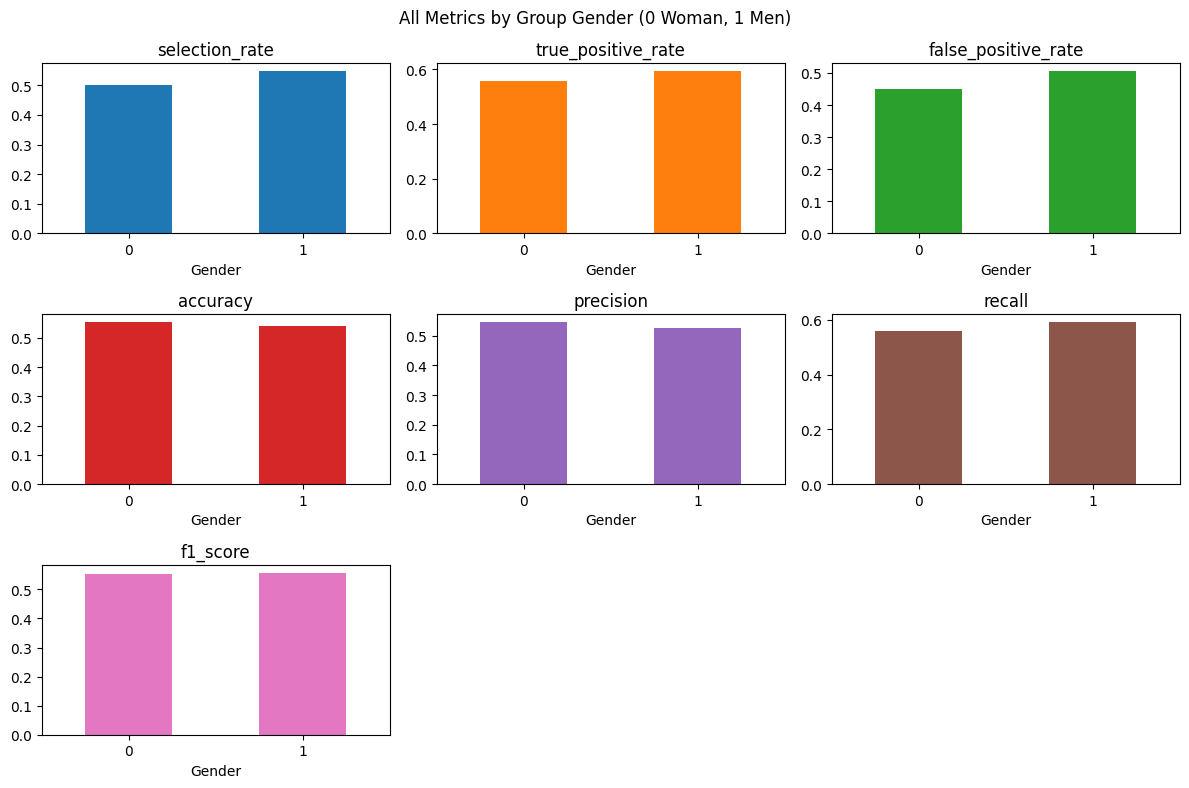

In [130]:
y_outcome = y_test  # observed decisions
sensitive_feature = X_test['Gender']  # e.g., "male", "female"

# For a data-only fairness evaluation, treat the observed outcome as both the true label and the prediction.
y_true = y_outcome
metrics = {
    "selection_rate": selection_rate,
    "true_positive_rate": true_positive_rate,
    "false_positive_rate": false_positive_rate,
    "accuracy": accuracy_score,
    "precision": precision_score,
    "recall": recall_score,
    "f1_score": f1_score
}
# Create a MetricFrame using a fairness metric. Here, we'll use the selection rate:
# (the proportion of individuals with a favorable outcome, which you can define as needed).
metric_frame = MetricFrame(
    metrics=metrics,
    y_true=y_true,
    y_pred=y_pred,
    sensitive_features=sensitive_feature
)

# 1. Plot all metrics by group using bar charts (each metric gets its own subplot)
metric_frame.by_group.plot.bar(
    subplots=True,
    layout=(3, 3),
    legend=False,
    figsize=(12, 8),
    sharex=False,       # Ensures each subplot has its own X-axis
    sharey=False,       # Ensures each subplot has its own Y-axis
    rot=0,              # Rotation for the X tick labels
    title="All Metrics by Group Gender (0 Woman, 1 Men)"
)

plt.tight_layout()
plt.show()


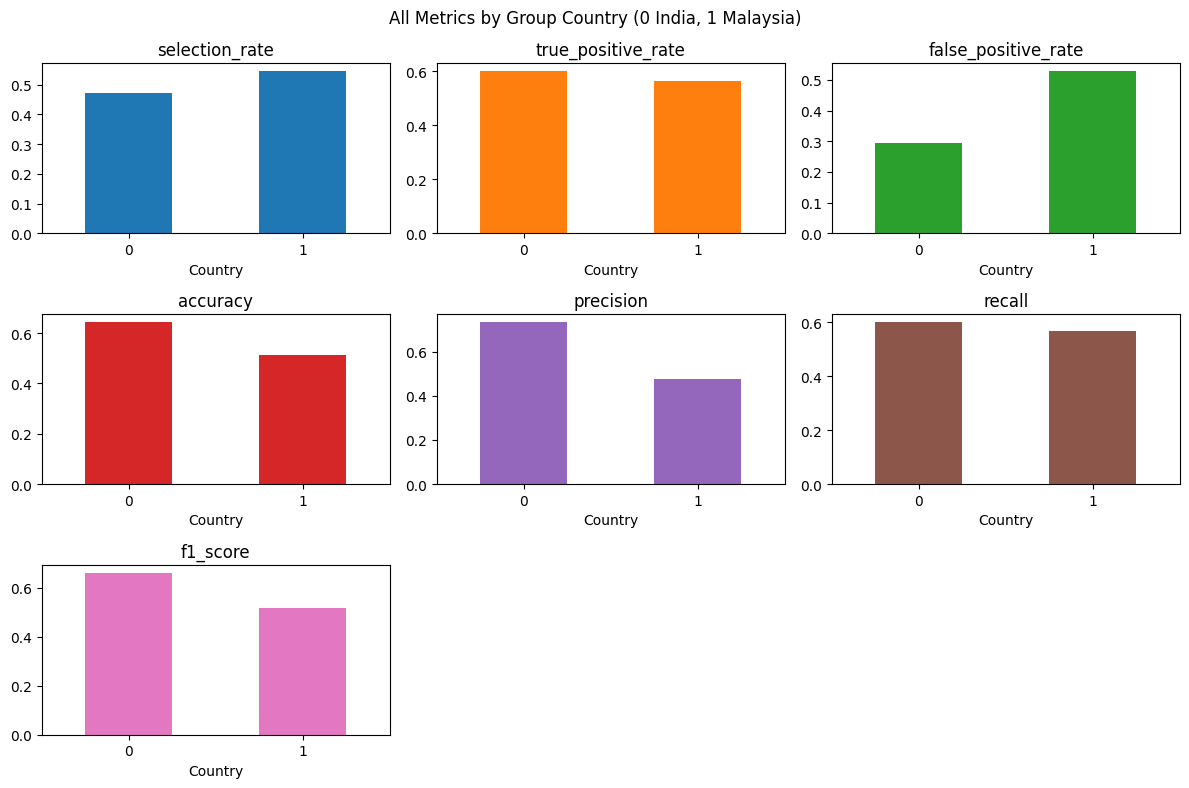

In [131]:
y_outcome = y_test  # observed decisions
sensitive_feature = X_test['Country']  # e.g., "male", "female"

# For a data-only fairness evaluation, treat the observed outcome as both the true label and the prediction.
y_true = y_outcome
metrics = {
    "selection_rate": selection_rate,
    "true_positive_rate": true_positive_rate,
    "false_positive_rate": false_positive_rate,
    "accuracy": accuracy_score,
    "precision": precision_score,
    "recall": recall_score,
    "f1_score": f1_score
}
# Create a MetricFrame using a fairness metric. Here, we'll use the selection rate:
# (the proportion of individuals with a favorable outcome, which you can define as needed).
metric_frame = MetricFrame(
    metrics=metrics,
    y_true=y_true,
    y_pred=y_pred,
    sensitive_features=sensitive_feature
)

# 1. Plot all metrics by group using bar charts (each metric gets its own subplot)
metric_frame.by_group.plot.bar(
    subplots=True,
    layout=(3, 3),
    legend=False,
    figsize=(12, 8),
    sharex=False,       # Ensures each subplot has its own X-axis
    sharey=False,       # Ensures each subplot has its own Y-axis
    rot=0,              # Rotation for the X tick labels
    title="All Metrics by Group Country (0 India, 1 Malaysia)"
)
plt.tight_layout()
plt.show()
